In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-faces-hq-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4482550%2F7682764%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241013%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241013T004956Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D180171b615418533d8f8965e842bd54c6e5c2becd7a909600aea02d75beee87397ba6470d2a55e9e36e503a7417782e7f4c5978dfbf7f35b036c0f5edf78974a1407bf65222ee88e50e94c0ea6707411ba32a83e3fc63d9526f84e269d1a8eb95a3e9df04c83ad623d62833ac436410999b52a40f9fdff9c75338d15ee098dc7d2dcdd507f8897133eb70cc0034e70f7872dab6444f754f85bbc0e786ac1ea3e2f877867c05be42b4620e1bfc6afd3c87c7a25b0bc15debbc1f9ffd50405dfc509d5b138791b3a0a60be27869a621d8a2b72228ec4fe51a23733682f36a41d394cbcf90c9a183e66f5d6c94be4825287ad22611ee033049fe563ee137e9ade44'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6955038084 bytes downloaded
Downloaded and uncompressed: animal-faces-hq-dataset
Data source import complete.


# 1. Introduction

   This is the final project for DTSA-5511 Introduction to Deep Learning. The purpose of this project is to develop a convolutional neural network to catogorize animal pictures in to one of three catagories; Cat, Dog, or Wild. This project is broken down into 3 main sections. First is initial exploratory data analysis of the dataset. Second is the design, build, training, and tuning of the CNN model. Third is an analysis on how the well model is working.

## 1.1 Data Set

   Dataset used is Animal Faces-HQ (AFHQ) a collection of animal faces catagorized as Dog, Cat, or Wild. Dataset was created in support of the research paper 'StarGAN v2: Diverse Image Synthesis for Multiple Domains'. All pictures are 512x512 resolution in RGB color. There is a total of 15803 png images.   

Data set provided by:
    
    Choi, Y., Uh , Y., Yoo , J., & Ha, J.-W. (2020). StarGAN v2: Diverse Image Synthesis for Multiple Domains. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

## 1.2 Libraries

In [27]:
# import
from glob import glob
import numpy as np
import pandas as pd
import keras,cv2,os
from tqdm import notebook,trange
import tqdm
import matplotlib.pyplot as plt
import cv2
import gc
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Exploratory Data Analysis (EDA)

## 2.1 Loading Data

In [14]:
# set base directory
path = '/kaggle/input/animal-faces-hq-dataset/'

# set path and label for each catagory
animal = [['cat/', 0],['dog/',1],['wild/',2]]

# test and train directory /kaggle/input/animal-faces-hq-dataset/train/cat
train_path = path + 'train/'
test_path = path + 'test/'

# create df of paths
# train path df
df_train = pd.DataFrame(columns=['path', 'label'])
for x, label in animal:
    df = pd.DataFrame({'path' : glob(os.path.join(train_path, x, '*.png'))})
    df['label'] = label
    df_train = pd.concat([df_train, df], ignore_index=True)

df_test = pd.DataFrame(columns=['path', 'label'])
for x, label in animal:
    df = pd.DataFrame({'path' : glob(os.path.join(test_path, x, '*.png'))})
    df['label'] = label
    df_test = pd.concat([df_test, df], ignore_index=True)

#df_shuffled = df_train.sample(frac=1).reset_index(drop=True)


In [5]:
# Function to load a set number of images
# function takes in 'n' number of images in batch and
# 'df' dataframe with file paths and square image size in 'p' pixels.

def batch_me(n, df, p = 512):
    # generate array for images
    images = np.zeros([n,p,p,3], dtype = np.uint8)
    # pull labels from df
    labels = np.squeeze(df['label'].to_numpy())[0:n]
    # read in images tqdm.notebook.tqdm
    for i, row in tqdm.notebook.tqdm(df.iterrows(), total=n):
        if i == n:
            break
        img = Image.open(row['path'])
        #bw = img.convert('L')
        images[i] = img

    return images,labels

In [4]:
df_train.head(3)

path label
0  /kaggle/input/animal-faces-hq-dataset/train/ca...     0
1  /kaggle/input/animal-faces-hq-dataset/train/ca...     0
2  /kaggle/input/animal-faces-hq-dataset/train/ca...     0

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14336 entries, 0 to 14335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    14336 non-null  object
 1   label   14336 non-null  object
dtypes: object(2)
memory usage: 224.1+ KB


In [6]:
# create batch of first n images
all = len(df_train)
n= all
X_train, y = batch_me(n,df_train)

  0%|          | 0/14336 [00:00<?, ?it/s]

In [8]:
y_train = np.asarray(y).astype(int)
y_train = to_categorical(y_train, num_classes=3)
print(X_train.dtype)
print(y_train.shape)

uint8
(14336, 3)


In [38]:
all2 = len(df_test)
n= all2
X_test, yt = batch_me(n,df_test)

  0%|          | 0/1467 [00:00<?, ?it/s]

In [39]:
y_test = np.asarray(yt).astype(int)
y_test = to_categorical(y_test, num_classes=3)
print(X_test.dtype)
print(y_test.shape)

uint8
(1467, 3)


## 2.2 Visualizations

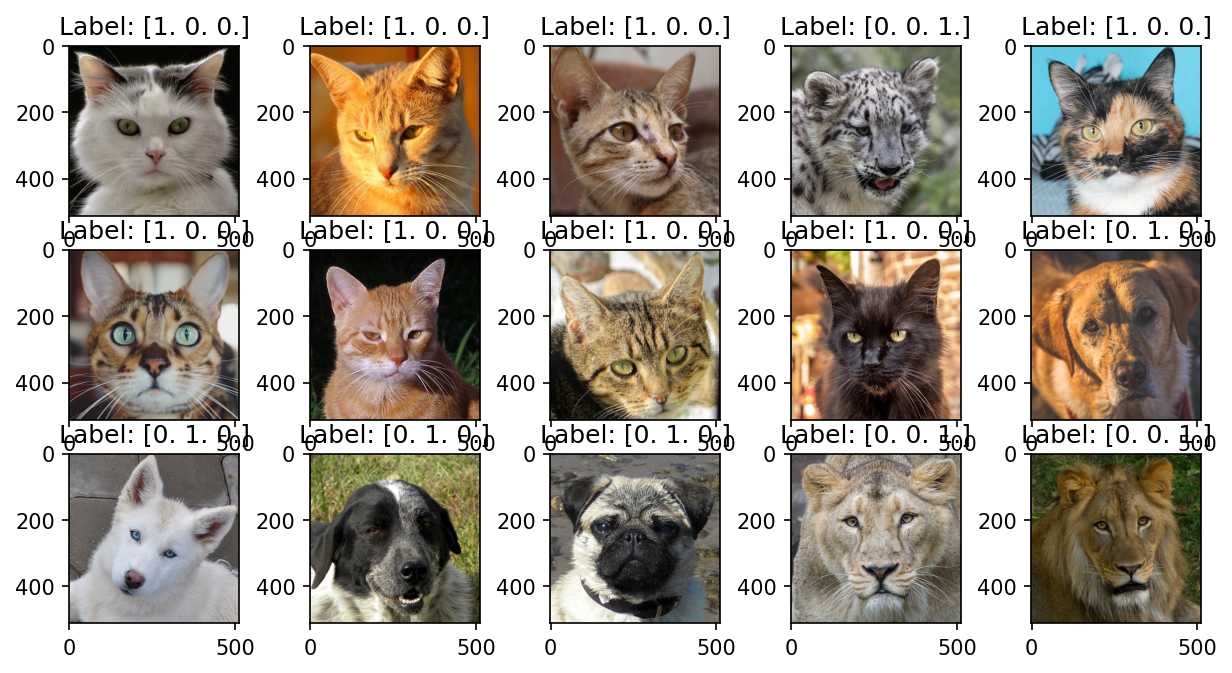

In [7]:
# display random 15 pictures with label
fig = plt.figure(figsize=(10, 5), dpi=150)
num = 15
for i in range(num):
    j = random.randint(0, all-1)
    ax = fig.add_subplot(3, 5, i + 1)
    plt.imshow(X_train[j], cmap='gray')
    ax.set_title('Label: ' + str(y_train[j]))

Text(0, 0.5, 'Counts')

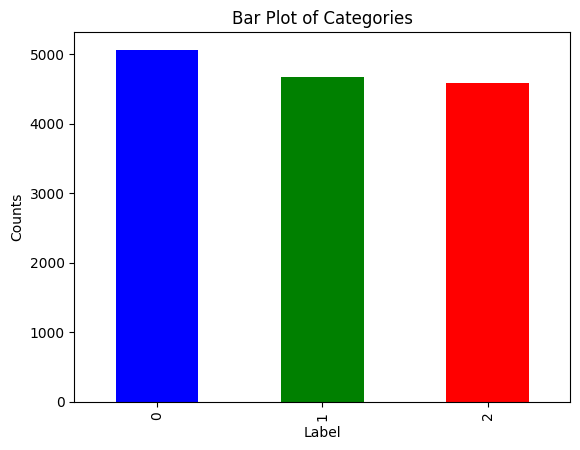

In [11]:
# distribution of labels
counts = df_train['label'].value_counts()
# Create bar plot
counts.plot(kind='bar', color=['blue', 'green', 'red'])

# Add title and labels
plt.title('Bar Plot of Categories')
plt.xlabel('Label')
plt.ylabel('Counts')

# Show plot


## 2.3 Preprocessing

Images dont need a whole lot of preprocessing and just need to apply an image generator. Images are clean and formated well but looking at the sample images above the images look very similar in layout and face size. Lets use imagedatagenerator to introduce some variability to the dataset. Hopefully this will allow the model to extract better features.

In [9]:
# Initialize ImageDataGenerator
batch = 8
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    brightness_range=[0.6,1.4],
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator1 = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=True)


Found 14336 images belonging to 3 classes.


In [15]:
print(X_batch.dtype)
print(X_batch.shape)

float32
(16, 512, 512, 3)


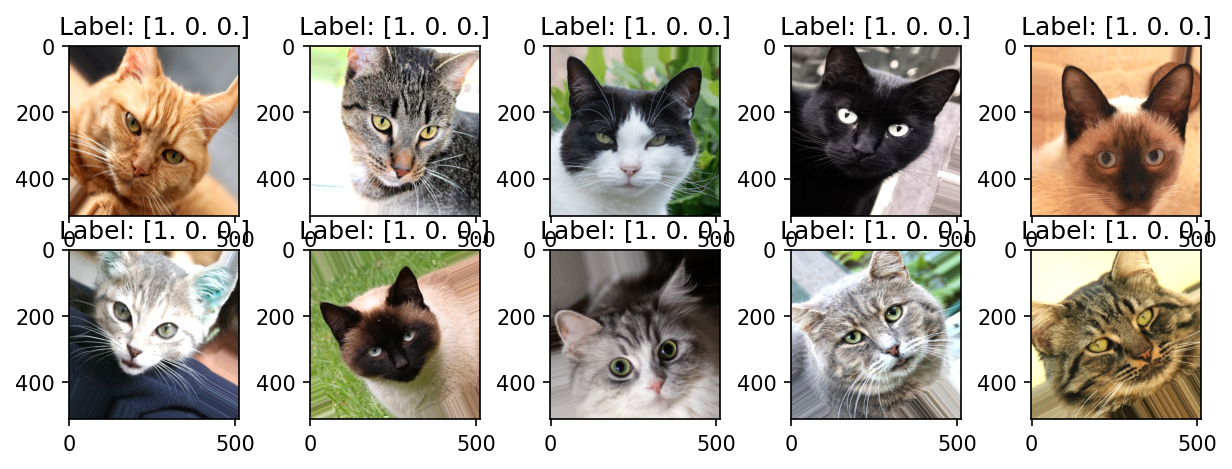

In [18]:
# Plot augmented images for review
fig = plt.figure(figsize=(10, 5), dpi=150)
num = 10
for i in range(num):
    ax = fig.add_subplot(3, 5, i + 1)
    plt.imshow(X_batch[i], cmap='gray')
    ax.set_title('Label: ' + str(y_batch[i]))

# 3. Model

## 3.1 Design

For the model I will be using a convolutional neural network (CNN) using Keras. This model will have an initial layout of 3 convolution layers, 1 dense layer, and a final output layer.   

## 3.2 Build

In [9]:
# parameters
kernel_size = (3,3)
pool_size= (2,2)
conv1 = 16
conv2 = 32
conv3 = 64
dense = 32
dropout_dense = 0.5
epoch = 5
rate = .0005

In [10]:
# model
model = Sequential()
model.add(Conv2D(conv1, kernel_size, input_shape = (512, 512, 3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))

model.add(Conv2D(conv2, kernel_size, use_bias=False))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))

model.add(Conv2D(conv3, kernel_size, use_bias=False))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))

model.add(Flatten())
model.add(Dense(dense, use_bias=False))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Output Layer
model.add(Dense(3, activation = "sigmoid"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 510, 510, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 32)        │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 253, 253, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 124, 124, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       7,872,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,896,099 (30.12 MB)

 Trainable params: 7,896,099 (30.12 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 Initial Training

In [12]:
# Train the initial model
mod_initial = model.fit(X_train, y_train, batch_size=batch, epochs = epoch)

Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.3565 - loss: 40.9473
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.3550 - loss: 1.0978
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.3575 - loss: 1.0974
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.3543 - loss: 1.0977
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.3535 - loss: 1.0977


In [16]:
# model fit with image generator
mod_generator1 = model.fit(train_generator1, epochs=epoch)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 969s 2s/step - accuracy: 0.3491 - loss: 1.0981
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 951s 2s/step - accuracy: 0.3534 - loss: 1.0976
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 945s 2s/step - accuracy: 0.3519 - loss: 1.0979
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.3517 - loss: 1.0978
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 951s 2s/step - accuracy: 0.3539 - loss: 1.0977


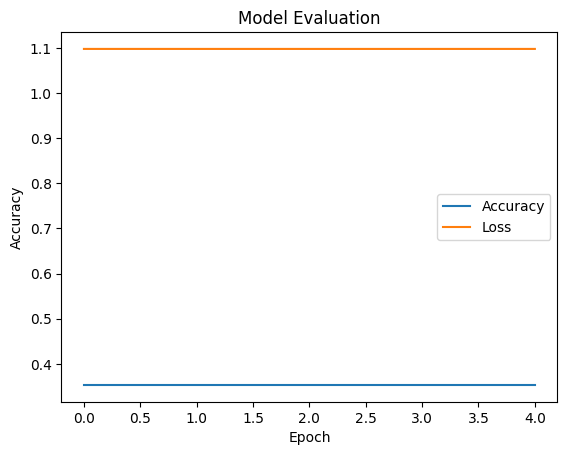

In [17]:
plt.plot(mod_generator1.history["accuracy"])
plt.plot(mod_generator1.history['loss'])


plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Loss"])

plt.show()

In [19]:
y_pred = model.predict(X_train)

448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step


In [20]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


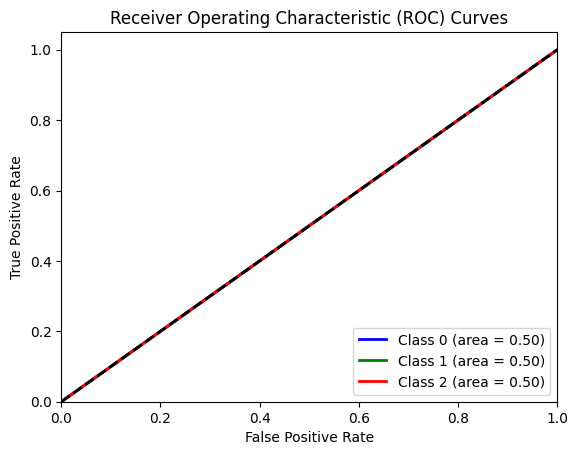

In [21]:
# Plot ROC curves
plt.figure()
colors = ['blue', 'green', 'red']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## 3.4 Tuning

Now on to tuning the model. I am approaching tuning from several different areas. First The parameters for each Convolution layer(kernel size, stride, pool size). Second the dimensions and depth of the Convolution layers. And last the size and parameters for the dense layer.  

In [10]:
# parameters
kernel1 = 7
kernel2 = 5
kernel3 = 3
pool_size= 1
stride1 = 2
stride2 = 2
stride3 = 2
conv1 = 128
conv2 = 256
conv3 = 384
conv4 = 512
conv5 = 1024
dense = 64
dropout_dense = 0.3
dropout_conv = .1
epoch = 25
rate = .00001
stop = EarlyStopping(monitor='accuracy', patience=5, verbose=1, mode='max', baseline=0.85)

In [11]:
# model
model2 = Sequential()
model2.add(Conv2D(filters = conv1, kernel_size = kernel1 , input_shape = (512, 512, 3)))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPool2D(pool_size = pool_size, strides = stride1))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(filters = conv2, kernel_size = kernel2 , padding='same'))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPool2D(pool_size = pool_size, strides = stride2))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(filters = conv3, kernel_size = kernel3 , padding='same'))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPool2D(pool_size = pool_size, strides = stride3))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(filters = conv4, kernel_size = kernel3 , padding='same'))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPool2D(pool_size = pool_size, strides = stride3))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(filters = conv5, kernel_size = kernel3 , padding='same'))
model2.add(LeakyReLU(alpha=0.3))
model2.add(MaxPool2D(pool_size = 2, strides = stride3))
model2.add(Dropout(dropout_conv))

model2.add(Flatten())
model2.add(Dense(dense, use_bias=False))
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))

# Output Layer
model2.add(Dense(3, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [12]:
# Compile the model
model2.compile(
    optimizer=SGD(learning_rate=rate, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 506, 506, 128)       │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 506, 506, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 253, 253, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 253, 253, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 256)       │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 253, 253, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 127, 127, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 127, 127, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 127, 127, 384)       │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 127, 127, 384)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 512)         │       1,769,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,990,531 (95.33 MB)

 Trainable params: 24,990,531 (95.33 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
mod2 = model2.fit(X_train, y_train, batch_size=batch, epochs = epoch, callbacks=[stop])
#mod_generator2 = model2.fit(train_generator1,
#                           epochs=epoch,
#                            steps_per_epoch=len(train_generator1),
#                            callbacks=[stop])

Epoch 1/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 142s 64ms/step - accuracy: 0.3558 - loss: 1.4748
Epoch 2/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.4598 - loss: 1.0254
Epoch 3/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.5548 - loss: 0.8937
Epoch 4/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.5937 - loss: 0.8223
Epoch 5/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.6081 - loss: 0.7886
Epoch 6/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.6278 - loss: 0.7364
Epoch 7/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.6627 - loss: 0.6886
Epoch 8/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.6891 - loss: 0.6345
Epoch 9/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.7162 - loss: 0.5930
Epoch 10/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.7328 - loss: 0.5617
Epoch 11/25
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.7483 - loss: 0.52

# 4. Model Visualization

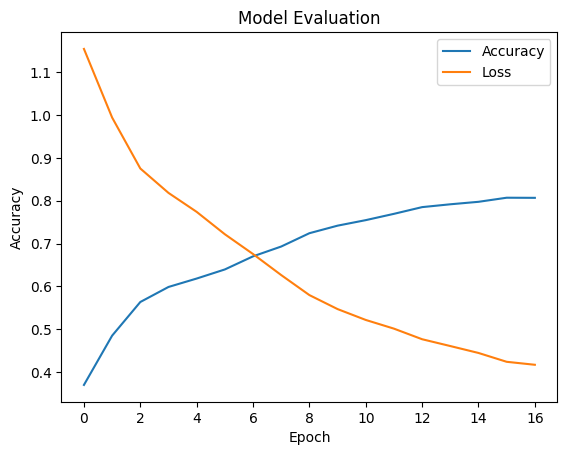

In [15]:
plt.plot(mod2.history["accuracy"])
plt.plot(mod2.history['loss'])


plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Loss"])

plt.show()

In [17]:
y_pred = model2.predict(X_train)

448/448 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step


In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


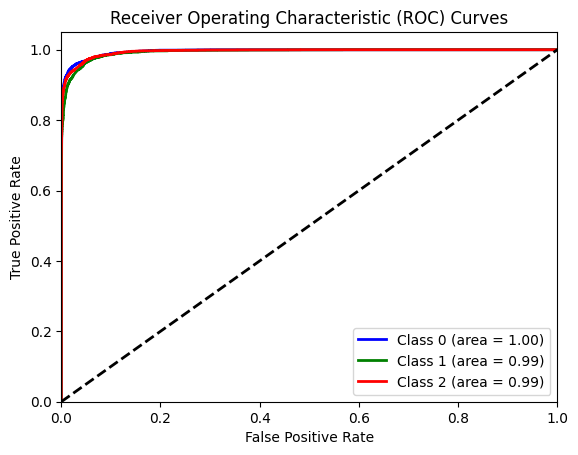

In [19]:
# Plot ROC curves
plt.figure()
colors = ['blue', 'green', 'red']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## 4.1 Convolution Layers

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


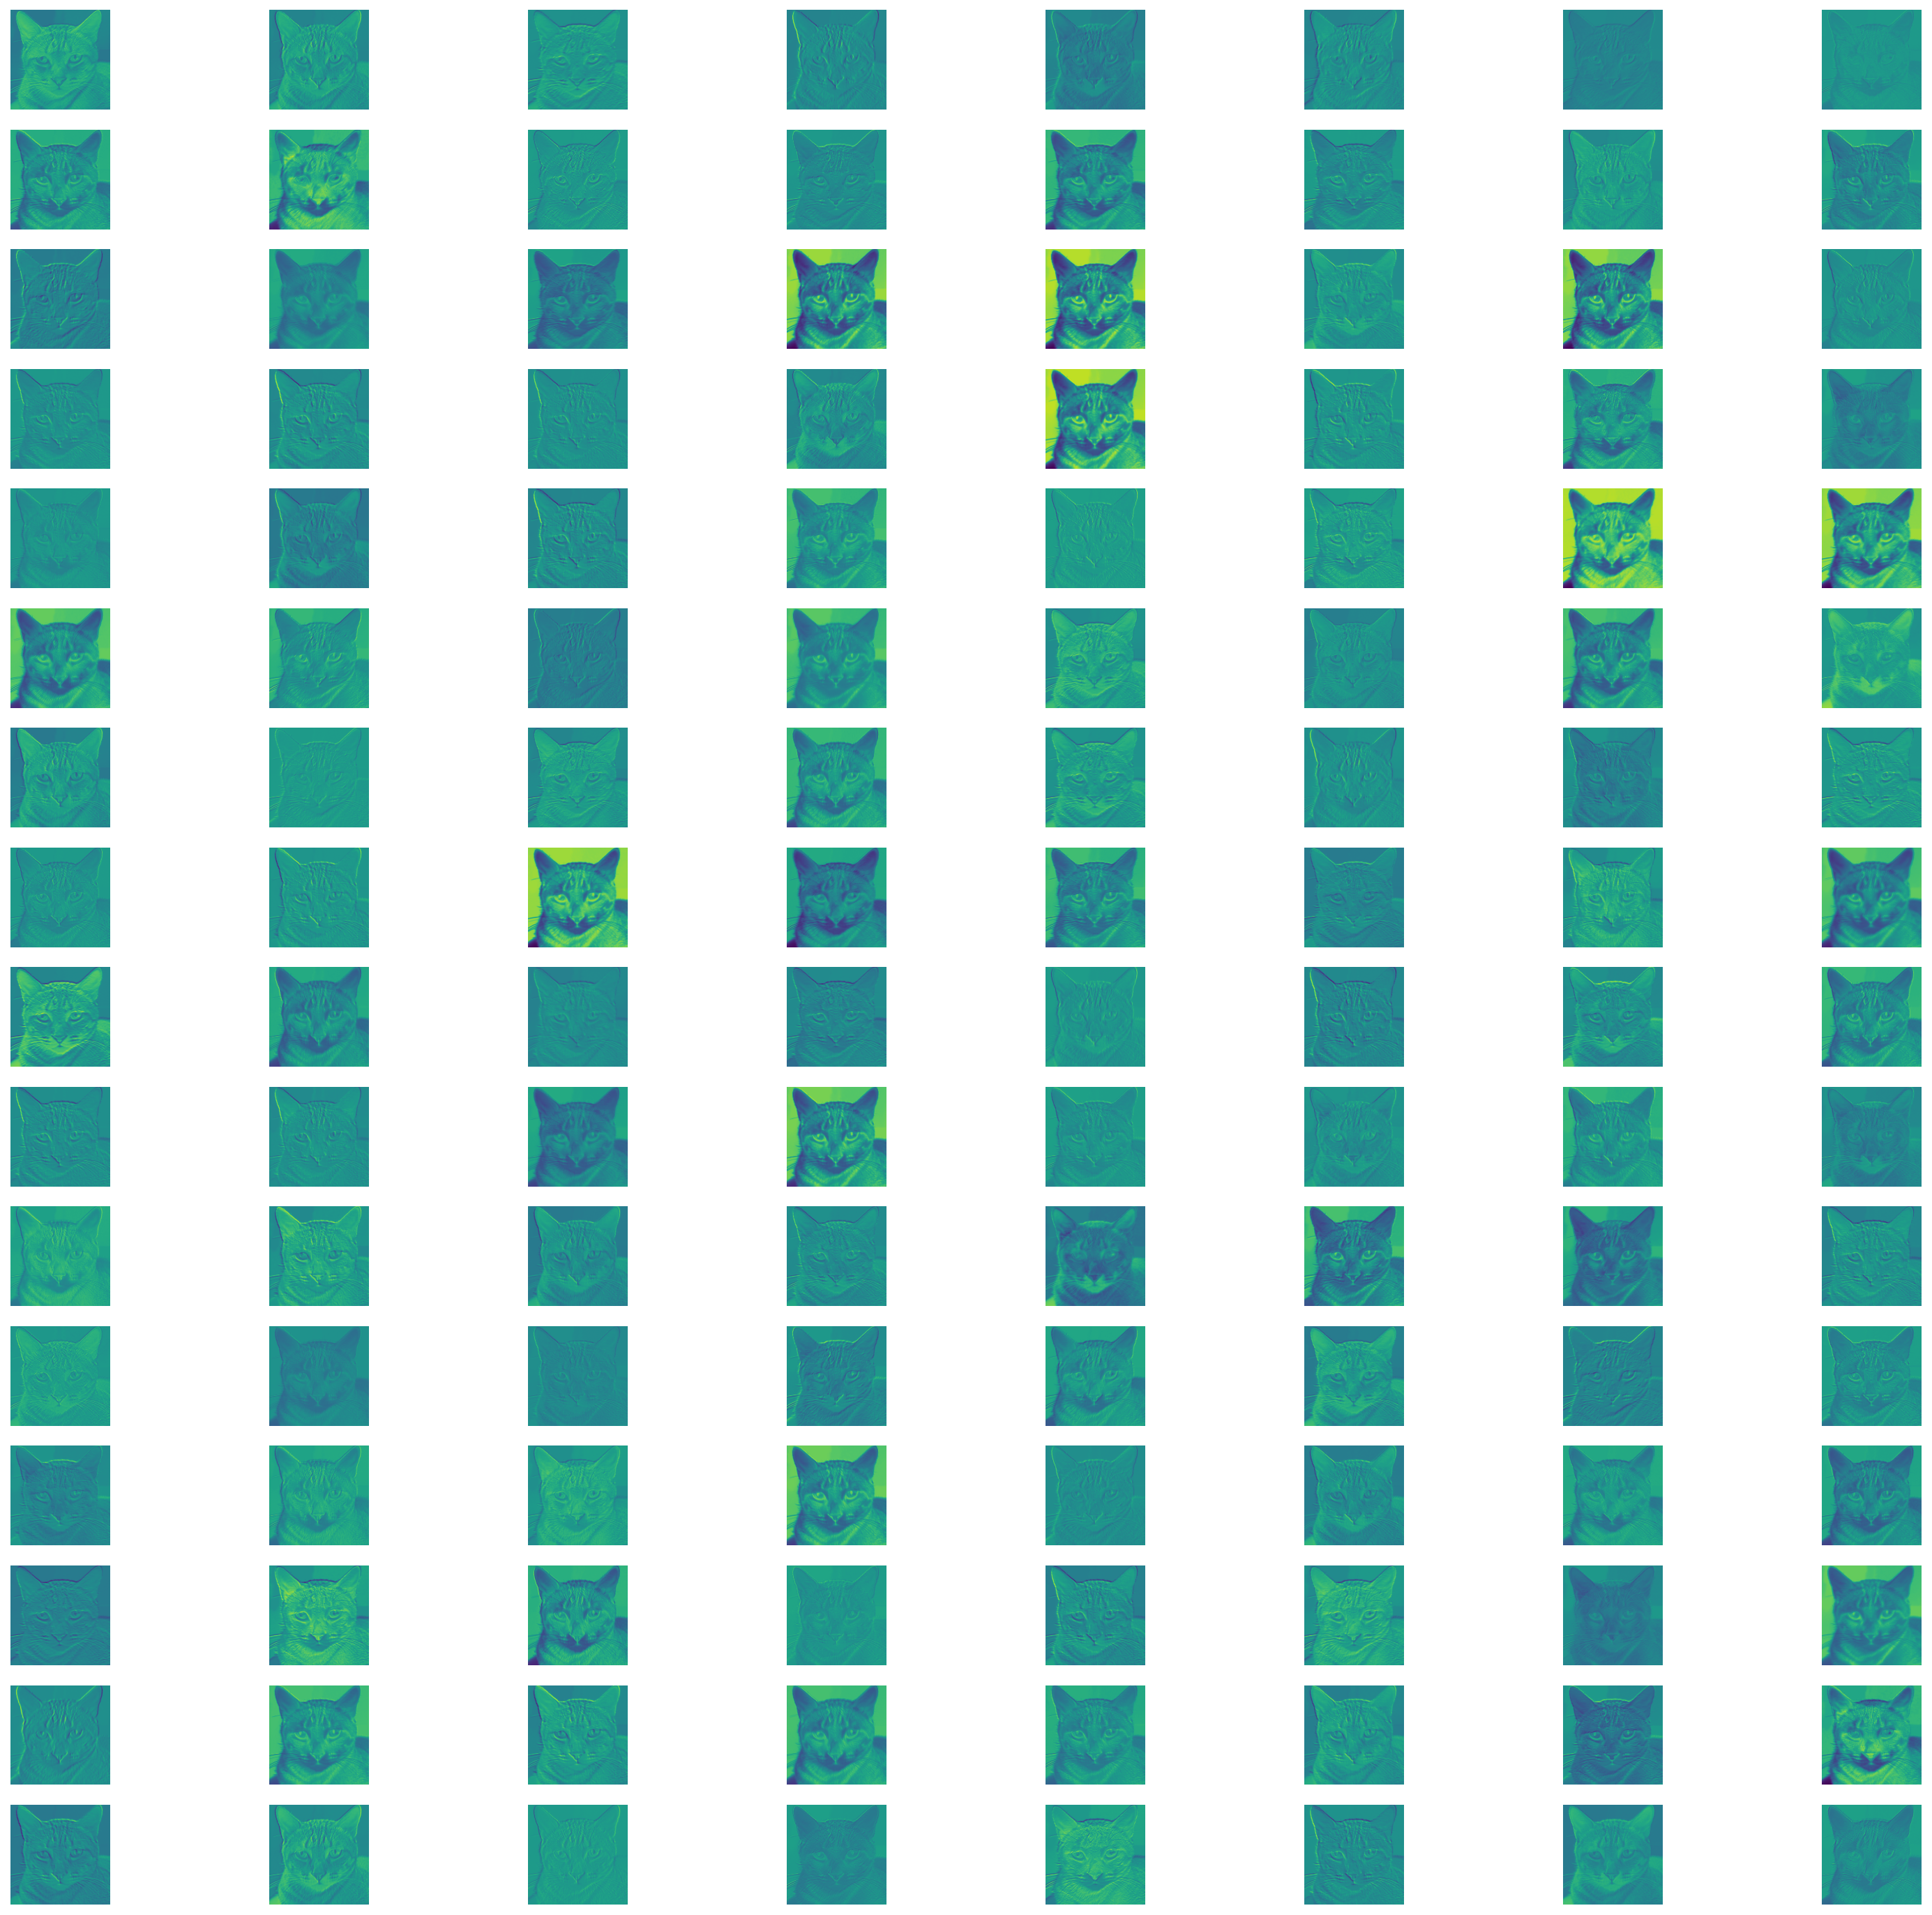

In [37]:

# Choose an image to visualize
image = X_train[0].reshape(1, 512, 512, 3)
model2.predict(image)
# Create a model that outputs feature maps from the convolutional layers
layer_outputs = [layer.output for layer in model2.layers if 'conv' in layer.name]
activation_model = Model(inputs=model2.inputs, outputs=layer_outputs)

# Get feature maps for the chosen image
feature_maps = activation_model.predict(image)

# Function to plot feature maps
def plot_feature_maps(feature_maps, layer_index):
    feature_map = feature_maps[layer_index]
    num_filters = feature_map.shape[-1]
    size = feature_map.shape[1]

    plt.figure(figsize=(25, 25), dpi=150)
    for i in range(num_filters):
        plt.subplot(num_filters // 8 + 1, 8, i + 1)
        plt.imshow(feature_map[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# Visualize feature maps for each convolutional layer
for i, feature_map in enumerate(feature_maps):
    plot_feature_maps(feature_maps, i)
    break

# 5. Results

In [41]:
# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9287 - loss: 0.2152
Test Accuracy: 0.91
Test Loss: 0.25


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step


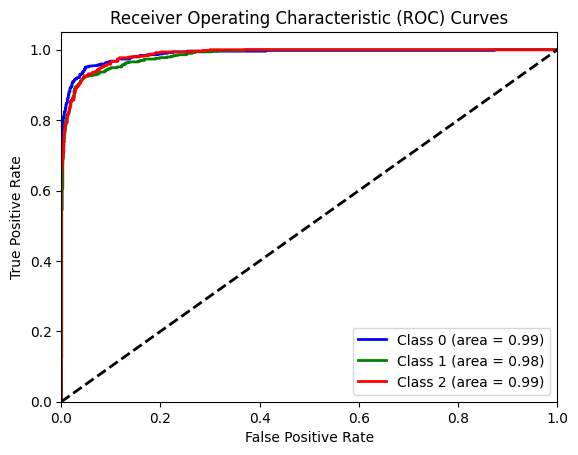

In [40]:
test_pred = model2.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['blue', 'green', 'red']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# 6. Conclusion

Final model achieved a an accuracy of .91 on the test dataset. Each category has a pretty equal classification rate.

Thank you for your time.